In [1]:
import sys
import os
# Add project directory to Python path
sys.path.append(r'F:\FYP_DATA\ml_project')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Load data
data_path = '../data/processed/process.csv'
if not os.path.exists(data_path):
    print(f'Relative path {data_path} not found, using absolute path')
    data_path = r'F:\FYP_DATA\ml_project\data\processed\process.csv'
    if not os.path.exists(data_path):
        raise FileNotFoundError(f'Data file not found at {data_path}')
df = pd.read_csv(data_path)
X = df.drop(columns=['Unnamed: 0', 'water_Discharge'], axis=1)
y = df['water_Discharge']



f:\FYP_DATA\ml_project\mynew312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0322 - mae: 0.1123 - val_loss: 0.0147 - val_mae: 0.0950
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0020 - mae: 0.0298 - val_loss: 0.0079 - val_mae: 0.0690
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0016 - mae: 0.0262 - val_loss: 0.0047 - val_mae: 0.0546
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0017 - mae: 0.0279 - val_loss: 0.0032 - val_mae: 0.0434
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0015 - mae: 0.0253 - val_loss: 0.0019 - val_mae: 0.0345
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0013 - mae: 0.0219 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0013 - mae: 0.0228 - val_loss: 8.4359e-04 - val_mae: 0.0230
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0012 - mae: 0.0213 - val_loss: 0.0021 - val_mae: 0.0381
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 2

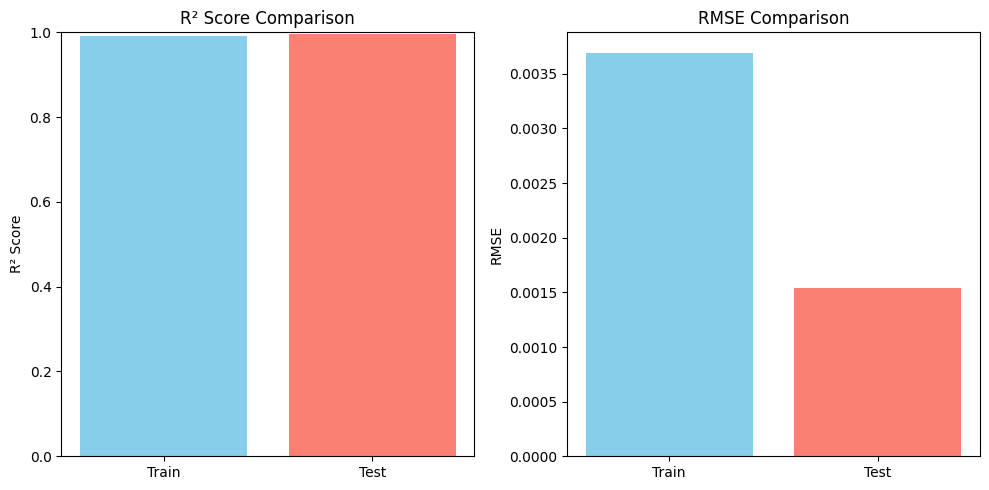

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


# 2. Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 3. Sequence preparation
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # All features except target
        y.append(data[i + window_size, -1])     # Target: water discharge
    return np.array(X), np.array(y)

window_size = 20
X, y = create_sequences(scaled_data, window_size)

# 4. Train-test split (no shuffle for time-series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6. Train model
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 7. Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse scaling
def inverse_target(scaled_y):
    dummy = np.zeros((len(scaled_y), scaled_data.shape[1]))
    dummy[:, -1] = scaled_y.flatten()
    return scaler.inverse_transform(dummy)[:, -1]

y_train_orig = inverse_target(y_train)
y_train_pred_orig = inverse_target(y_train_pred)
y_test_orig = inverse_target(y_test)
y_test_pred_orig = inverse_target(y_test_pred)

# 8. Evaluate
print("\n📊 Training Results")
print("R² Score:", r2_score(y_train_orig, y_train_pred_orig))
print("RMSE:", mean_squared_error(y_train_orig, y_train_pred_orig))

print("\n📊 Testing Results")
print("R² Score:", r2_score(y_test_orig, y_test_pred_orig))
print("RMSE:", mean_squared_error(y_test_orig, y_test_pred_orig))

# 10. Metrics for bar graph
train_r2 = r2_score(y_train_orig, y_train_pred_orig)
test_r2 = r2_score(y_test_orig, y_test_pred_orig)

train_rmse = mean_squared_error(y_train_orig, y_train_pred_orig)
test_rmse = mean_squared_error(y_test_orig, y_test_pred_orig)

# 11. Plotting bar graphs
plt.figure(figsize=(10, 5))

# R² Score comparison
plt.subplot(1, 2, 1)
plt.bar(['Train', 'Test'], [train_r2, test_r2], color=['skyblue', 'salmon'])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# RMSE comparison
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [train_rmse, test_rmse], color=['skyblue', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.tight_layout()
plt.savefig("../result/plots_of_actu_vs_pred/r2of_lstm.png")  
plt.show()
